# Visualization Clinical Reasoning

Author: Brian Locke MD MSCI

Assistant Professor (Clinical Investigation)

Dept. of PCCM, Intermountain Health

## Overview: 

### Goal: Graphically depict reasoning using our quintile system

- First, explain assumptions of a simple dichotomous model (do they have disease X, or not?) using Leaf Plots
- Second, explore assumptions around integrating data from multiple tests
- Third, derive a 'qualitative Bayesian' logistic-regression model that is usable for findings without substantial prior research
- Fourth, generalize findings to multi-class (several options, 1 of which is correct) and multi-label (several possible diseases, each may be present or not)

### Key Decisions: 

[ ] do we need to be able to automatically extract whether each feature was present?  (if so, would use an LLM like chatGPT to do the natural language processing)

[ ] ultimate use? (e.g. - do we want this to be "normative"? (e.g. how *should* learners have updated their ddx?)). Yes, but we need to validate the performance of this with expert intuitions. 

[ ] how can we incorporate the various sources of uncertainty? (e.g. how useful are the pieces of evidence? how certain was the answer? what are the base-rates?)

### TODO: 

[ ]  Finish this and send out: 
[ ] evaluate known features - How close are the major features that we came up with to the standard? 



In [1]:
# This workbook will use Python 
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import math
from collections import namedtuple

## Part 1: Theoretical Considerations

### Basic Bayesian Reasoning

First, let's allow that probability can represent uncertainty about the the world (epistemic uncertainty) in addition to the frequency of events occuring with repeated sampling (aleatoric undertainty). This is the core of Bayesian statistics (vs frequentist, which only allows aleatoric uncertainty). 

Probabilities take a value between 0 and 1.

How these probabilities are qualitiatively described in English is variabile and problematic, so lets roughly use the Intelligence Communities labels:
 
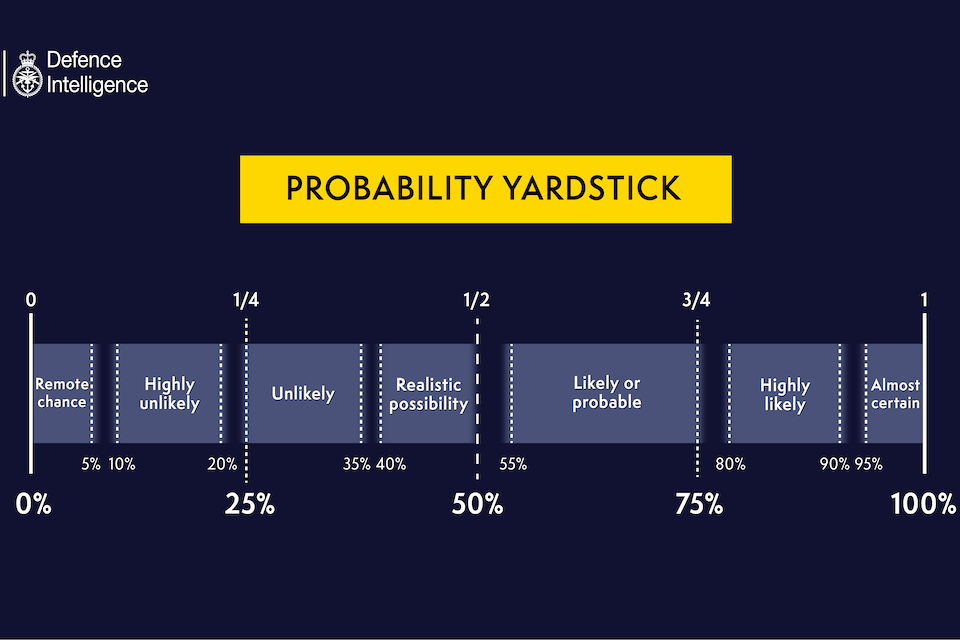

In [2]:
Range = namedtuple("Range", ["low", "high"])

old_certainty_ranges = {
    "HIGHLY_UNLIKELY": Range(0, 0.2),
    "UNLIKELY": Range(0.2, 0.4),
    "UNCERTAIN": Range(0.4, 0.6),
    "LIKELY": Range(0.6, 0.8),
    "HIGHLY_LIKELY": Range(0.8, 1)
}

However, Bayes theorem uses odds and not probability.

Odds: 
$$
\text{Odds of an event} = \frac{\text{Probability of the event}}{\text{Probability of the event not happening}}
$$

This is sometimes written as: 
$$
\text{Odd} = \frac{\text{P}}{\text{1 - P}}
$$

Odds take values between 0 and infinity. 

Likelihood ratios represent how much you should update your assessment of how likely something is with new information. The likelihood ratio formulation of Bayes theorem uses odds as inputs and outputs. 

Relationship between pre-test and post-test odds:
$$
\text{Post-test Odds} = \text{Pre-test Odds} \times \text{Likelihood Ratio}
$$

In Python, the post-test probability can be calculated by: 

1. First, converting the pre-test probability to odds. 
2. Second, multiplying the pre-test odds by the likelihood ratio to calculate the post-test odds
3. Third, converting the post-test odds to probability 

In [3]:
def probability_to_odds(probability):
    """Convert probability to odds."""
    return probability / (1 - probability)

def calc_post_test_odds(pre_test_odds, likelihood_ratio):
    """Calculate post-test odds from pre-test odds and likelihood ratio."""
    return pre_test_odds * likelihood_ratio

def odds_to_probability(odds):
    """Convert odds to probability."""
    return odds / (1 + odds)

def calc_post_test(pre_test_prob, likelihood_ratio):
    """Takes Pre-test and LR and calculates post-test probability."""
    pre_test_odds = probability_to_odds(pre_test_prob)
    post_test_odds = calc_post_test_odds(pre_test_odds, likelihood_ratio)
    post_test_prob = odds_to_probability(post_test_odds)
    return post_test_prob

In the context of disease diagnostics, likelihood ratios can be generated by: 

$$
\text{Likelihood ratio(finding)} = \frac{P(\text{finding} \mid \text{disease})}{P(\text{finding} \mid \text{no disease})}
$$

where the parenthesis mean "of" and the bar "|" means "when there is". A finding could refer to a test result, an exam finding, a historical feature from the HPI, or any other piece of evidence.

This value can be calculated if you know four frequencies: 

- A: Number of people with the disease and the finding
- B: Number of people with the disease and not the finding
- C: Number of people without the disease and with the finding
- D: Number of people with neither the disease nor the finding

If you know those things, you can calculate the likelihood ratio for a positive test as:

$$
LR^+ = \frac{\frac{A}{A+B}}{\frac{C}{C+D}}
$$
and 
$$
LR^- = \frac{\frac{B}{A+B}}{\frac{D}{C+D}}
$$

The exact formula isn't as important as recognizing that both the frequency of cases (people with disease: A and B) and non-cases (C and D) are required for the LR's to be accurate. 

This means, the *spectrum of cases and non-cases* where the LR's were derived from must be similar to the case where you apply the LRs. 

### ASSUMPTION 1: Spectrum of cases and noncases for derived estimates is simpilar to where Bayes will be applied


#### Question
What is the implication of using odds instead of probabilities for Bayes rule? 

#### Answer
It means that stronger evidence is needed to go from P = 0.8 (= odds 4) to 0.9 (= odds 9, requires LR 2.25) than from 0.7 (= odds 2.33) to 0.8 (= odds 4, requires LR 1.71)... and going from 0.9 (= odds 9) to 1.0 (= odds infinity) takes utterly conclusive evidence. 

### Leaf Plot

We can visualize this relationship with a leaf plot and several hypothetical findings of various strengths. The x-axis represents the pre-test probability and the y-axis represents the post-test probabilities if you had a finding 

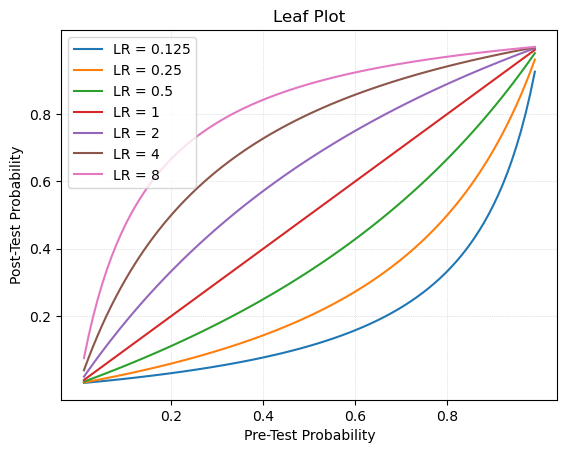

In [4]:
def leaf_plot(likelihood_ratios=None, grid_positions=None):
    """Plots a Leaf Plot.

    Args:
        likelihood_ratios (list, optional): A list of likelihood ratios to plot.
        grid_positions (list, optional): A list of grid positions for x and y axes.
    """

    pre_test_probs = np.arange(0.01, 1, 0.01)
    
    # Default likelihood_ratios if none are provided
    if likelihood_ratios is None:
        likelihood_ratios = [0.125, 0.25, 0.5, 1, 2, 4, 8]

    fig, ax = plt.subplots()
    for lr in likelihood_ratios:
        post_test_probs = [calc_post_test(p, lr) for p in pre_test_probs]
        ax.plot(pre_test_probs, post_test_probs, label=f"LR = {lr}")

    # Set grid positions at 0.2, 0.4, 0.6, and 0.8 corresponding to qualitative categories

    # Default grid_positions if none are provided
    if grid_positions is None:
        grid_positions = [
            old_certainty_ranges["HIGHLY_UNLIKELY"][1], 
            old_certainty_ranges["UNLIKELY"][1], 
            old_certainty_ranges["UNCERTAIN"][1], 
            old_certainty_ranges["LIKELY"][1]
        ]
    ax.set_xticks(grid_positions)
    ax.set_yticks(grid_positions)

    # Add faint dotted grid lines
    ax.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7)

    ax.set_xlabel("Pre-Test Probability")
    ax.set_ylabel("Post-Test Probability")
    ax.set_title("Leaf Plot")
    ax.legend()
    plt.show()

if __name__ == "__main__":
    leaf_plot()

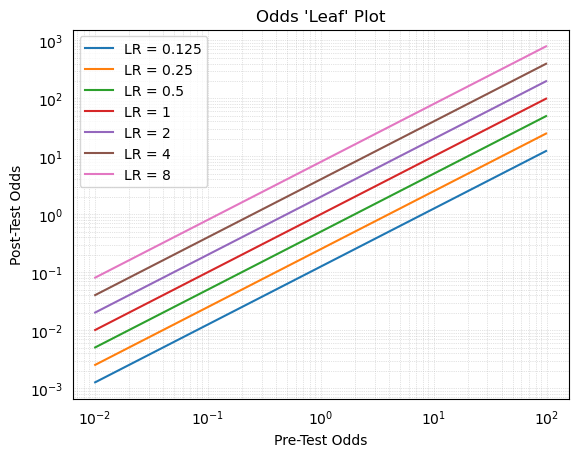

In [5]:
def odds_leaf_plot(likelihood_ratios=None, grid_positions=None):
    """Plots an Odds Leaf Plot.

    Args:
        likelihood_ratios (list, optional): A list of likelihood ratios to plot.
        grid_positions (list, optional): A list of grid positions for x and y axes in odds.
    """

    # Generate pre-test probabilities and convert to odds
    pre_test_probs = np.arange(0.01, 1, 0.01)
    pre_test_odds = probability_to_odds(pre_test_probs)
    
    # Default likelihood_ratios if none are provided
    if likelihood_ratios is None:
        likelihood_ratios = [0.125, 0.25, 0.5, 1, 2, 4, 8]

    fig, ax = plt.subplots()
    for lr in likelihood_ratios:
        post_test_odds = [calc_post_test_odds(o, lr) for o in pre_test_odds]
        ax.plot(pre_test_odds, post_test_odds, label=f"LR = {lr}")

    # Default grid_positions if none are provided (set using predefined odds ranges)
    if grid_positions is None:
        grid_positions = [probability_to_odds(p) for p in [0.2, 0.4, 0.6, 0.8]]

    # Add faint dotted grid lines with logarithmic axes
    ax.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7)

    ax.tick_params(which='both', bottom=False, left=False)  # Disable minor ticks
    ax.set_xticks(grid_positions)
    ax.set_yticks(grid_positions)

    ax.set_xscale('log')  # Set x-axis to logarithmic scale
    ax.set_yscale('log')  # Set y-axis to logarithmic scale

    ax.set_xlabel("Pre-Test Odds")
    ax.set_ylabel("Post-Test Odds")
    ax.set_title("Odds 'Leaf' Plot")
    ax.legend()
    plt.show()

if __name__ == "__main__":
    odds_leaf_plot()

### Log-odds

Likelihood ratios summarize the strength of evidence, with stronger evidence being further from 1. However, the scale is weird: a finding with a LR 0.5 is equivalently strong evidence as an LR of 2. The only difference is that the direction is switched. 

This is because likelihood ratios are *ratios* , and thus are best represented on a multiplicative scale rather than an additive (linear) one. Meaning *halving* the odds and *doubling* the odds represent similarly informative events. 

Logarithms enable us to convert this multiplicative scale to a linear one (and exponentiating allows you to go back). If we take the logarithm of both sides of Bayes formula we get: 

$$
\log(\text{Post-test Odds}) = \log(\text{LR}) + \log(\text{Pre-test Odds})
$$

Recall, that Log (A * B) = Log(A) + Log(B). Log(odds of A) is often shortened/said as "Log-odds(A)" and the Log(LR) is sometimes called the "Weight of Evidence". The log scale is often referred to as the 'logit' scale. 

Logarithms are unintuitive to everyone, but this expression has several nice features: 
- A finding with a Log(LR) -1 (= LR 0.5) and a finding with a log(LR) = 1 (= LR = 2) are equally informative, and equally far from 0 (= not at all informative)
- If the log-odds of an event happening is 0, odds = 1 and p = 0.5 (meaning, it is equally likely to happen as not). Evidence will move the log-odds away from 0 linearly with how strong the evidence is (e.g. if the log-odds is 2, then twice as much as evidence in favor has been mustered as if log-odds is 1)

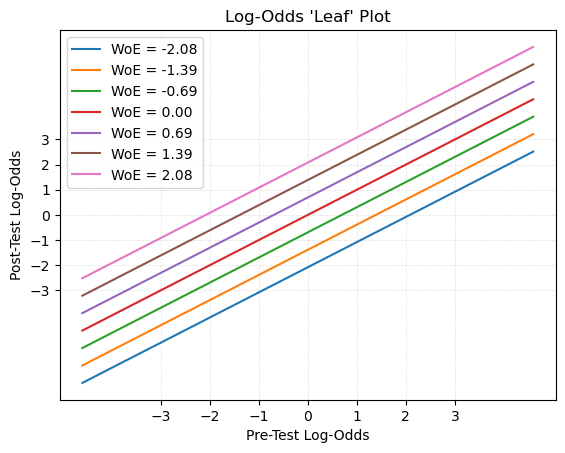

In [6]:
def prob_to_log_odds(prob):
    """
    Convert a probability to log-odds.

    Parameters:
    prob (float): Probability value between 0 and 1 (exclusive).

    Returns:
    float: Corresponding log-odds.
    """
    if prob <= 0 or prob >= 1:
        raise ValueError("Probability must be strictly between 0 and 1.")
    return math.log(prob / (1 - prob))

def log_odds_to_prob(log_odds):
    """
    Convert log-odds to probability.

    Parameters:
    log_odds (float): Log-odds value.

    Returns:
    float: Corresponding probability.
    """
    return math.exp(log_odds) / (1 + math.exp(log_odds))

def calc_post_test_log_odds(pre_test_log_odds, weight_of_evidence):
    """Calculate post-test log-odds from pre-test log-odds and weight of evidence."""
    return pre_test_log_odds + weight_of_evidence

def log_odds_leaf_plot(weights_of_evidence=None, grid_positions=None):
    """Plots a Log-Odds Leaf Plot.

    Args:
        weights_of_evidence (list, optional): A list of weights of evidence (log(likelihood ratios)) to plot.
        grid_positions (list, optional): A list of grid positions for x and y axes in log-odds.
    """

    # Generate pre-test probabilities and convert to log-odds
    pre_test_probs = np.arange(0.01, 1, 0.01)
    pre_test_odds = probability_to_odds(pre_test_probs)
    pre_test_log_odds = np.log(pre_test_odds)
    
    # Default weights_of_evidence if none are provided
    if weights_of_evidence is None:
        likelihood_ratios = [0.125, 0.25, 0.5, 1, 2, 4, 8]
        weights_of_evidence = np.log(likelihood_ratios)

    fig, ax = plt.subplots()
    for wo in weights_of_evidence:
        post_test_log_odds = [calc_post_test_log_odds(lo, wo) for lo in pre_test_log_odds]
        ax.plot(pre_test_log_odds, post_test_log_odds, label=f"WoE = {wo:.2f}")

    # Default grid_positions if none are provided
    if grid_positions is None:
        grid_positions = np.linspace(-3, 3, 7)  # Example grid spanning -3 to 3 log-odds

    ax.set_xticks(grid_positions)
    ax.set_yticks(grid_positions)

    # Add faint dotted grid lines
    ax.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7)

    ax.set_xlabel("Pre-Test Log-Odds")
    ax.set_ylabel("Post-Test Log-Odds")
    ax.set_title("Log-Odds 'Leaf' Plot")
    ax.legend()
    plt.show()

if __name__ == "__main__":
    log_odds_leaf_plot()

### Summary: 

In many ways, the log scale is the natural "scale" to think about evidence because the strength of evidence is represented in a linear fashion. Evidence can be summed. 

## Part 2: Multiple tests

One can imagine that when multiple pieces of evidence are available (e.g. multiple tests, multiple exam findings, etc.), you can apply Bayes rule on the first test, followed by the second. 

$$
\text{Post-test-1 Odds} = \text{Pre-test Odds} \times \text{Likelihood Ratio-1}
$$

then 

$$
\text{Post-test-2 Odds} = \text{Post-test-1 Odds} \times \text{Likelihood Ratio-2}
$$

or, equivalently

$$
\text{Post-test-2 Odds} = \text{Pre-test Odds} \times \text{Likelihood Ratio-1} \times \text{Likelihood Ratio-2}
$$

### Independence of tests

However, both tests must provide independent evidence for this to accurately describe reality. For example, if you ask a question about "do you have known coronary artery disease?" and "do you have cerebrovascular disease?", those aren't two independent pieces of information because they both partially represent one predictor: do you have sequalae of atherosclerosis. 

What this means is that the first question does not add the same amount of information if the first question has already been answered. 


Example from Newman and Kohn about tests for Downs Syndrome

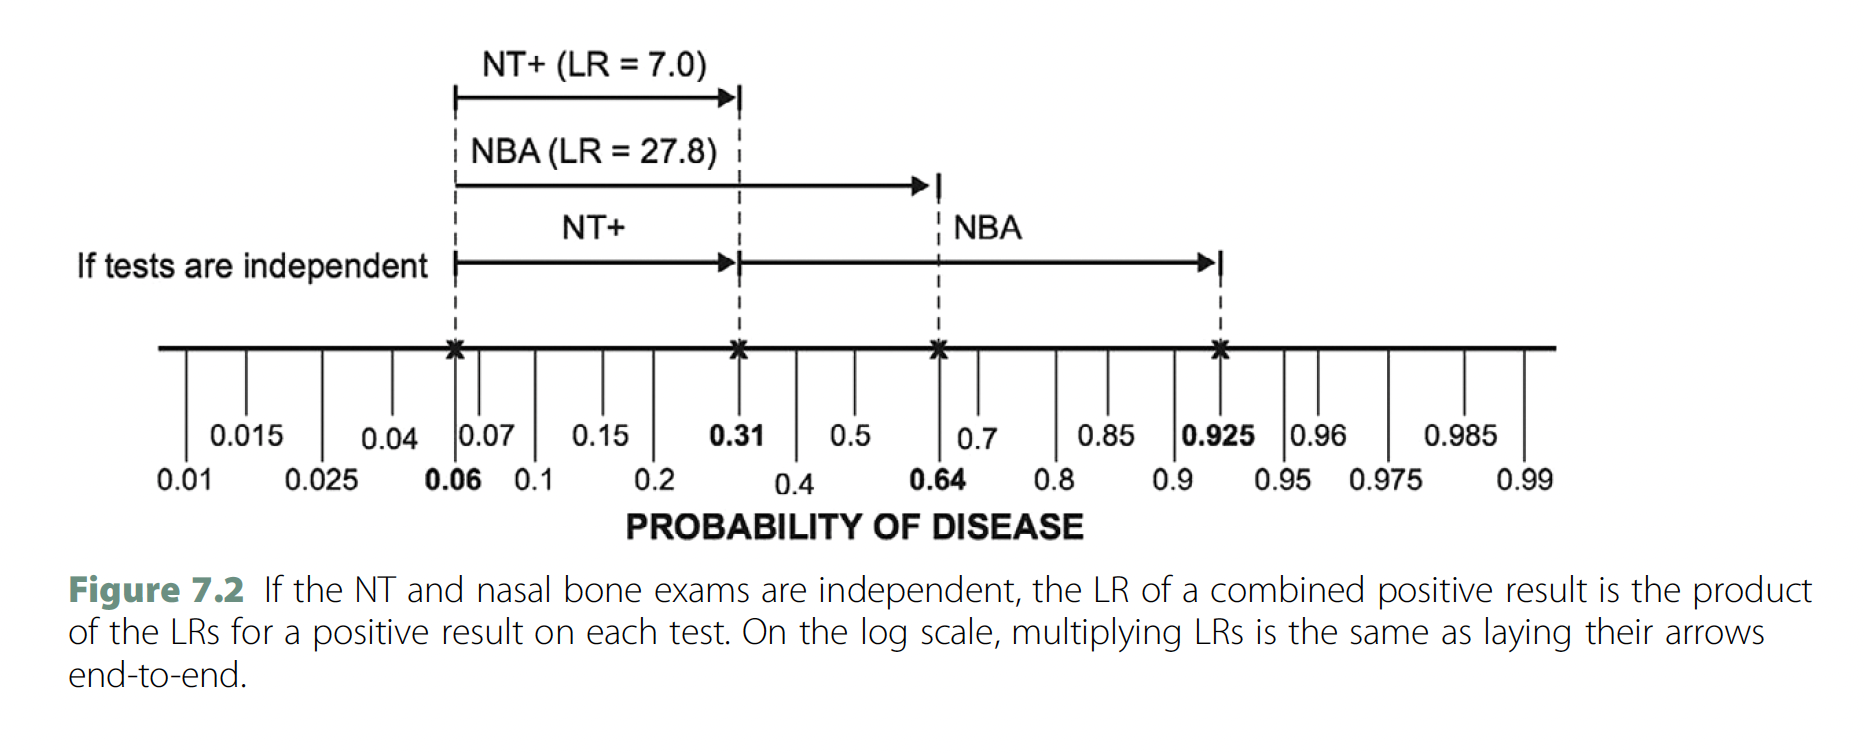

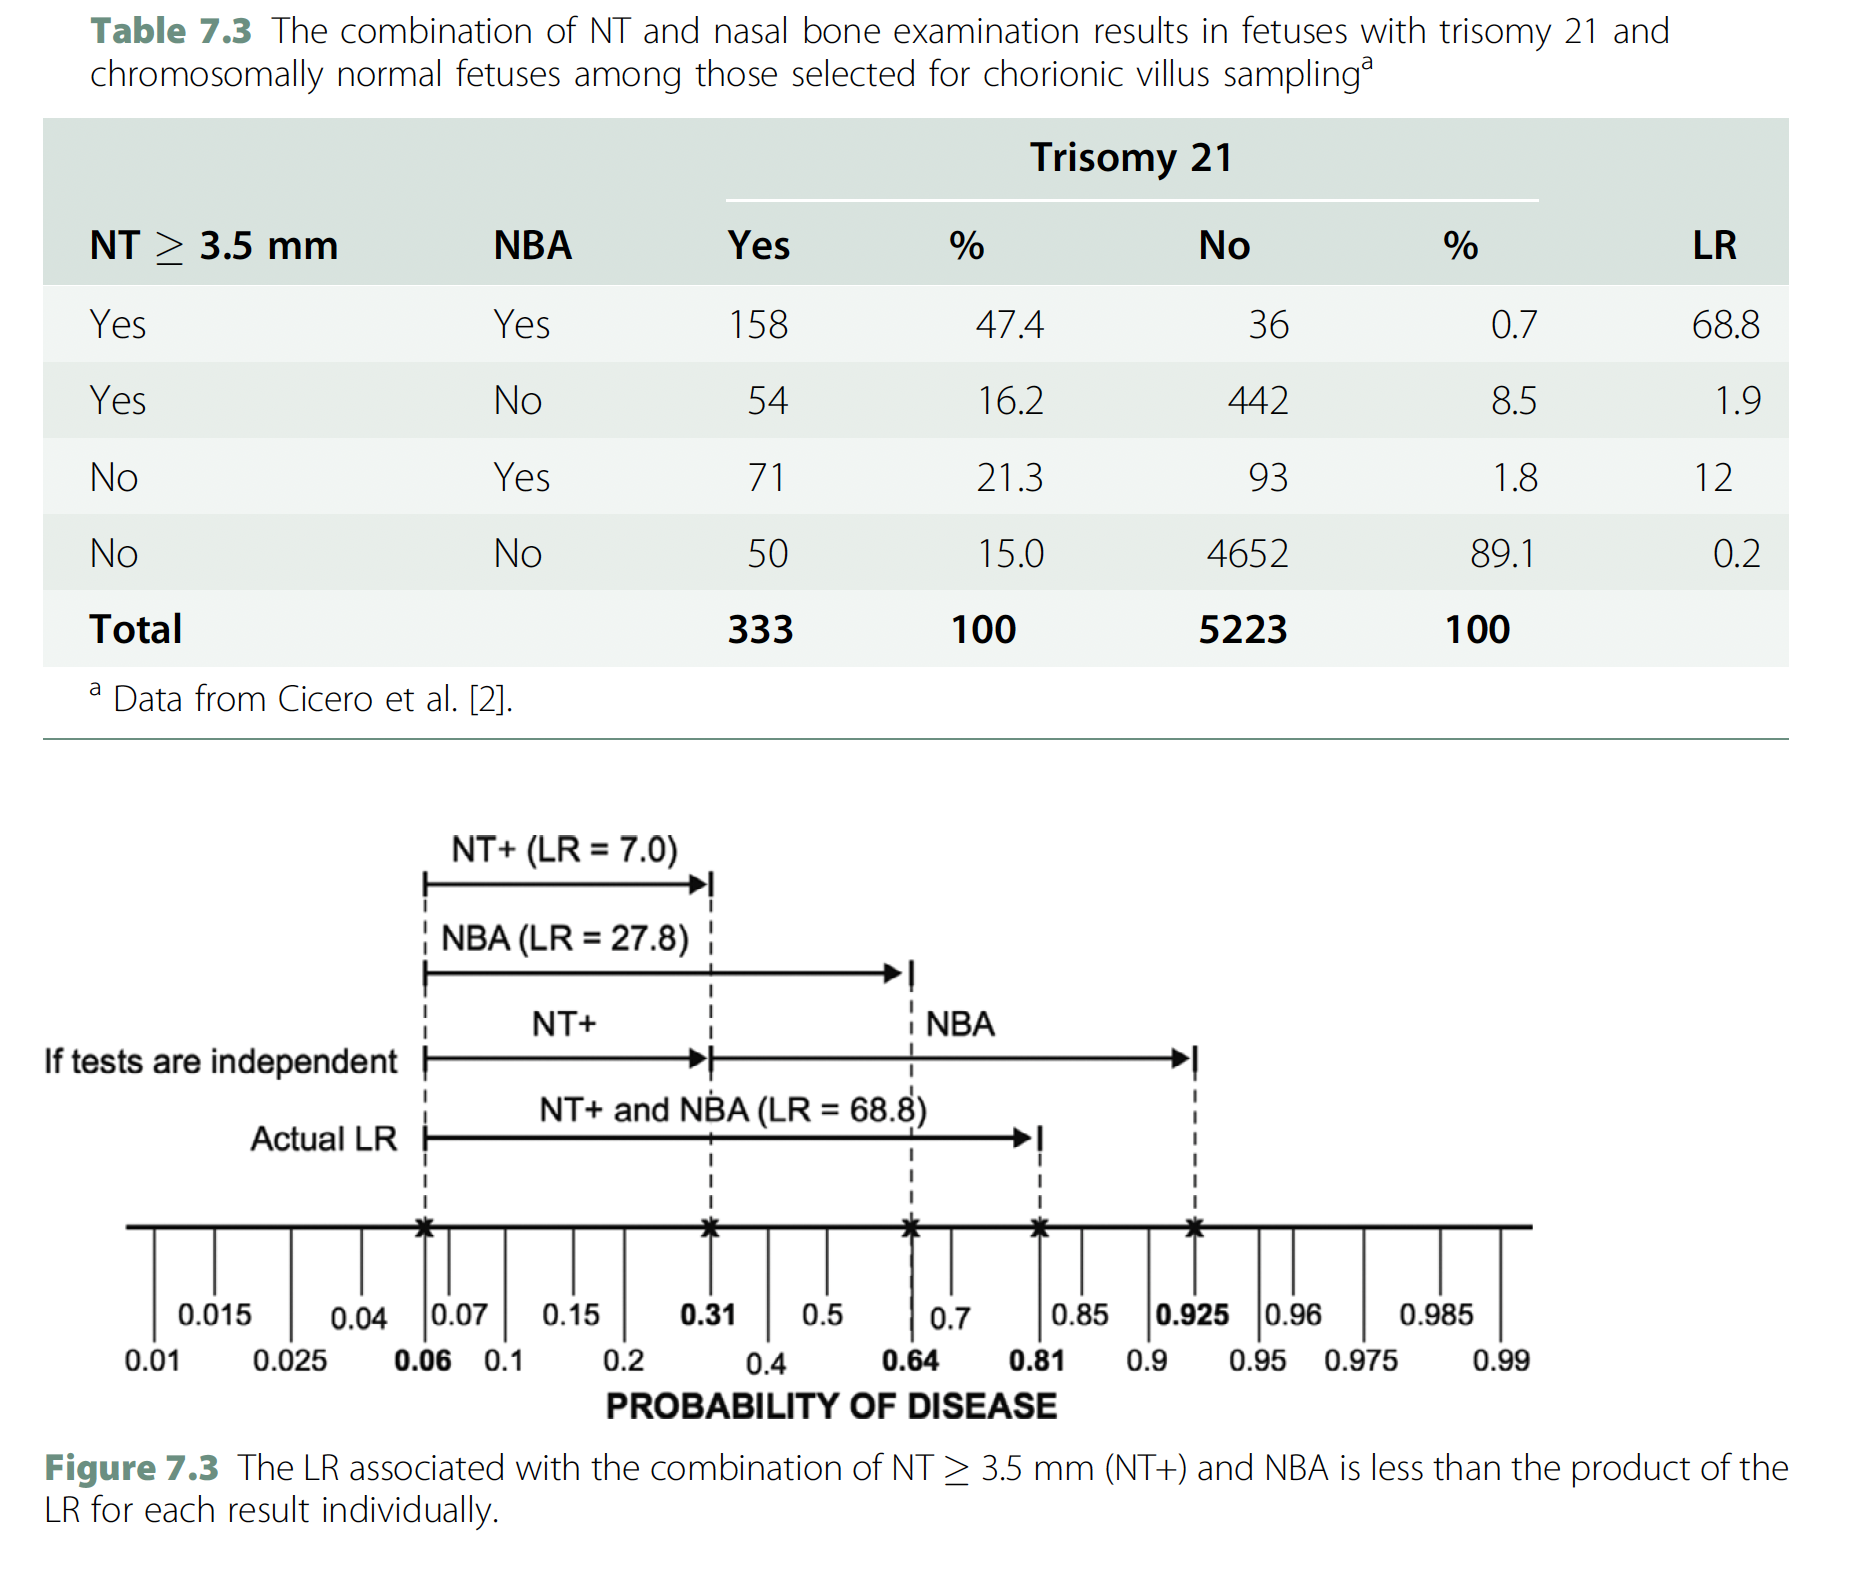

Assuming the evidence is independent is often called "Naive Bayes" in machine learning, which often works suprisingly well despite not being true. 


### ASSUMPTION 2: Independence of Tests

In [7]:
# Example: Here are the LR- values for the absence of risk factors: 

# No prior abnormal stress test: LR- = 0.92 
# No peripheral arterial disease: LR- = 0.96 
# No prior coronary artery disease: LR- = 0.75 
# No prior myocardial infarction: LR- = 0.88 
# No diabetes: LR- = 0.90 
# No cerebrovascular disease: LR- = 0.97 
# No hyperlipidemia: LR- = 0.85 
# No hypertension: LR- = 0.78 

"""
play around with the LRs in "Column E" to operationalize these metrics

asked 22 questions in this interview. Whether or not they captured key features for each "node" or "diagnosis" is designated in Column A as a "Y" (yes) or "N" (no). 

You'll notice the key features are weighted according to our major vs minor scales. The excel sheet multiplies major features in the positive direction by 6, major features in the negative direction by 3, minor features in the positive direction by 2, and minor features in the negative direction by 1. """

'\nplay around with the LRs in "Column E" to operationalize these metrics\n\nasked 22 questions in this interview. Whether or not they captured key features for each "node" or "diagnosis" is designated in Column A as a "Y" (yes) or "N" (no). \n\nYou\'ll notice the key features are weighted according to our major vs minor scales. The excel sheet multiplies major features in the positive direction by 6, major features in the negative direction by 3, minor features in the positive direction by 2, and minor features in the negative direction by 1. '

## Qualitative Bayes

In the real world, no-one bothers to estimate precise pre-test probabilities (or odds; or log-odds) nor calculate precise post-test probabilities. Nor should they: 

- precise estimates of LR's that correctly describe the spectrum of disease (violation of the spectrum of cases and non-cases) are usually not available.  
- we don't know how most findings interact with other findings (violations of the independence)
- we are often not reasoning about just cases and non-cases, but rather multiple diseases which may explain the patient's chief complaint (discussed below)
- we usuall don't *need* to know precise estimates - just close enough to make the right decision is enough.

Yet, the framework is probably still useful if it gets you in the right ballpark. 

So, maybe we can use a framework that only relies on rough estimates to get us roughly correct. 

### Do we need to modify our qualitative probability categories based on quintiles? 

Above, we said we'd call 0-20% highly unlikely, 20-40% unlikely, 40-60% uncertain, 60-80% certain, and 80-100% highly certain. 

As explained above, the "log-odds" scale is a much simpler scale to represent informativeness (we will return to this). In log odds, those probabilities convert to: 

In [8]:
probabilities = [0.2, 0.4, 0.6, 0.8]
odds = [probability_to_odds(prob) for prob in probabilities] # Convert each probability to log-odds
print("Odds:", [f"{od:.3f}" for od in odds])

log_odds = [prob_to_log_odds(prob) for prob in probabilities] # Convert each probability to log-odds
print("Log-Odds:", [f"{lo:.3f}" for lo in log_odds])

Odds: ['0.250', '0.667', '1.500', '4.000']
Log-Odds: ['-1.386', '-0.405', '0.405', '1.386']


As we can see, these are not evenly spaced categories, which will be a problem if we want LR's to have roughly similar effects between categories. 

However, if we choose categories that are evenly spaced on the log-odds scale and define labels that correspond to the amount of evidence to jump between categories, the math will work. 

In [9]:
log_odds = [-1.5, -0.5, 0.5, 1.5] # arbitrary choice based on roughly how strong most evidence is. 
probabilities = [log_odds_to_prob(lo) for lo in log_odds]
print("Probabilities: ",  [f"{prob:.3f}" for prob in probabilities])

Probabilities:  ['0.182', '0.378', '0.622', '0.818']


Meaning, our new categories are: 

- 0% - 18.2%: Highly Unlikely
- 18.2% to 37.8% Unlikely
- 37.8% to 62.2% Uncertain
- 62.2% to 81.8% Likely
- 81.8% to 100% Highly Likely. 

And, if we were going to generate representative point estimates for each category, they might correspond to: 

In [10]:
log_odds = [-2, -1, 0, 1, 2] # arbitrary choice based on roughly how strong most evidence is. 
probabilities = [log_odds_to_prob(lo) for lo in log_odds]
print("Probabilities: ",  [f"{prob:.3f}" for prob in probabilities])

Probabilities:  ['0.119', '0.269', '0.500', '0.731', '0.881']


mathematically, these are the geometric means (aka the mean on the logarithmic scale) of the ranges

- 11.9%: Highly Unlikely
- 26.9% Unlikely
- 50% Uncertain
- 73.1% Likely
- 88% Highly Likely. 

A natural next question would be, how strong does the evidence need to be to move up or down 1 qualitative category? 

In the log-odds scale, it is easy to see that 'weight of evidence' (WoE) = 1 would on average move you up 1 qualitative category and WoE = -1 would move you down a category. 

Exponentiating these WoE's to return them to likelihood ratios yields: 

$$
\exp(1) = e \approx 2.718
$$
and
$$
\exp(-1) = \frac{1}{e} \approx 0.368
$$

If we say a "strong feature" is one that changes the odds of a disease being present by 1 qualitative category, the LR+ is roughly 2.718 and the LR- is 0.368 


We can confirm this is true in probability-space using a leaf diagram. If you start (x-axis) anywhere in each bin and get a positive result, you move up a category on the y-axis (and vice-versa for a negative result) 

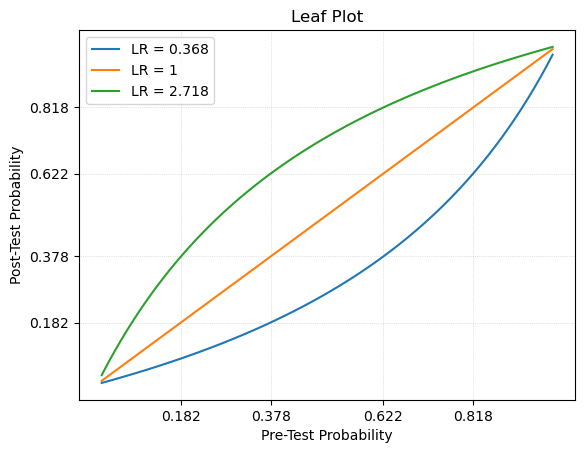

In [11]:
# new certainty estimates: 
certainty_ranges = {
    "HIGHLY_UNLIKELY": Range(0, 0.182),
    "UNLIKELY": Range(0.182, 0.368),
    "UNCERTAIN": Range(0.368, 0.622),
    "LIKELY": Range(0.622, 0.818),
    "HIGHLY_LIKELY": Range(0.818, 1)
}

def get_certainty_label(probability):
# Function to find the corresponding key
    for label, range_ in certainty_ranges.items():
        if range_.low <= probability < range_.high:
            return label
    return "Out of range"

# representative estimates for calcs
certainty_estimates = {
    "HIGHLY_UNLIKELY": 0.119,
    "UNLIKELY": 0.269,
    "UNCERTAIN": 0.5,
    "LIKELY": 0.731,
    "HIGHLY_LIKELY": 0.881
}

custom_gps = [0.182, 0.378, 0.622, 0.818] # corresponds to log-odds:  -1.5, -0.5, 0.5, 1.5 -> 
custom_lrs=[0.368, 1, 2.718] # corresponds to evidence needed to move 1 cat LR of e or 1/e moves a category
leaf_plot(likelihood_ratios= custom_lrs, grid_positions=custom_gps)

Or, more easily seen in logarthmic space

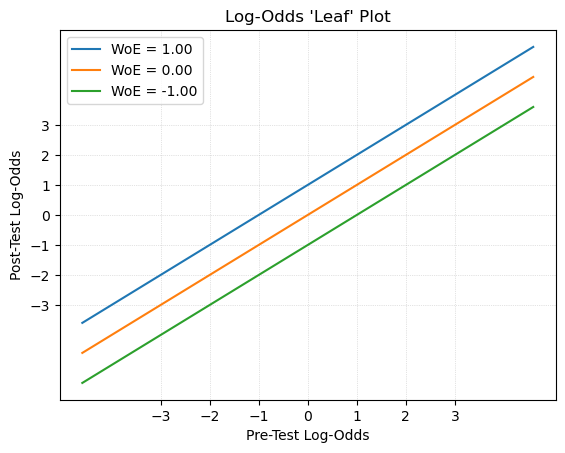

In [12]:
likelihood_ratios = [math.e, 1, 1/math.e]
weights_of_evidence = np.log(likelihood_ratios)

log_odds_leaf_plot(weights_of_evidence)

#### Major and Minor Criteria

It has been noted that positive features tend to be stronger than negative features (see [ ]source, cifu?). 

We wanted to define major and minor criteria such that they represent common cateagories, which we arbitrarily defined as: 

- 1 major positive criteria = move up a category of certainty
- 3 minor positive criteria = move up a category of certainty
- 2 major negative criteria = move down a category of certainty
- 6 minor negative criteria = move down a category of certainty

With that specification, it is easiest to see the weight of evidence (log-odds) would be: 

- Major positive = WoE of 1, +LR 2.718
- Minor positive = WoE of 1/3, +LR 1.396
- Major negative = WoE of -1/2, -LR 0.846
- Minor negative = WoE of -1/6, -LR -0.607

This passes the 'plausibility test' that it corresponds to the strength of many predictors. We can visualize it in probability space using another leaf diagram

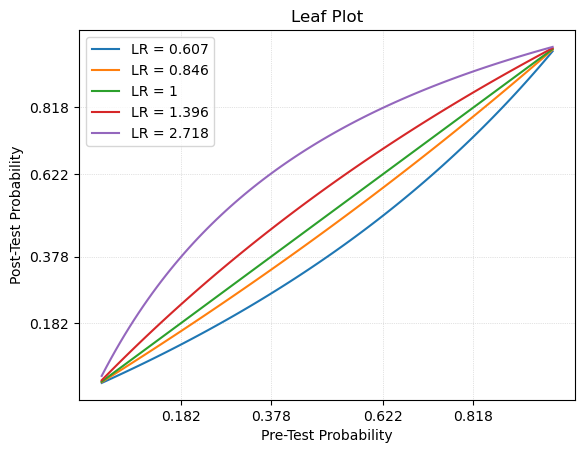

In [13]:
custom_gps = [0.182, 0.378, 0.622, 0.818] # corresponds to log-odds:  -1.5, -0.5, 0.5, 1.5
custom_lrs=[0.607, 0.846, 1, 1.396, 2.718]
leaf_plot(likelihood_ratios= custom_lrs, grid_positions=custom_gps)

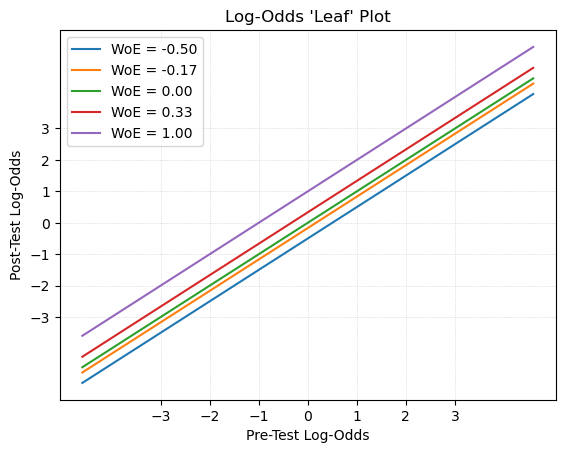

In [14]:
custom_woes= np.log([0.607, 0.846, 1, 1.396, 2.718])
log_odds_leaf_plot(weights_of_evidence=custom_woes)

The range of strengths of predictors that would be categorized as each type (major+, minor+, major-, minor-) are also clear to calculate in logarithmic space: 

- Major positive: WoE 2/3 or higher, LR+ of 1.948 or higher
- Minor positive: WoE of 2/3 to 1/6, LR+ of 1.181 to 1.948
- Not sufficiently informative to bother: 1/6 to -1/12, LR- of 0.920 to 1.181
- Minor negative: WoE of -1/12 to -1/3, LR- 0.717 to 0.920 
- Major negative: WoE -1/3 or lower, LR- below 0.717

## Enter, Logistic Regression

Above, I mentioned that the log-odds scale is sometimes referred to as the logit scale - which may have reminded you of logistic regression. 

To briefly review, logistic regression is used when you want to take 1 or more predictors and estimate the probability of each of two outcomes (traditionally, 0 and 1). How it works is that linear predictors are combined, then the result is transformed by a sigmoid link function to constrain the output to probability space (0 to 1). Here is an excellent review of how this works: https://mlu-explain.github.io/logistic-regression/ 

Overall, the form is: 

$$
P(y = 1 | X) = \text{sigmoid}(z) = \frac{1}{1 + e^{-z}}
$$

where

$$
z = \hat{\beta}_0 + \hat{\beta}_1 x_1 + \hat{\beta}_2 x_2 + \dots + \hat{\beta}_k x_k
$$

where z is collectively referred to as the linear predictor, sigmoid is the link function, beta_0 is an intercept , and beta 1 through k are predictors. 

### What's this have to do with our Qualitative Bayes? 

Recall: 

- Post-test odds+ / Pretest Odds = +LR 
- Post-test odds- / Pretest Odds = -LR

and 

- Post-test odds+ / Post-test odds- = OR

Also recall that the exponentiated coefficients from a logistic regression also give you the odds ratio associated with changing 1 unit in the predictor variable. 

Therefore, we can define a logistic regression where the only predictor is the cumulative Weight of Evidence of all features and the intercept is the starting log odds. 

$$
P(y = 1 | X) = \text{sigmoid}(z) = \frac{1}{1 + e^{-z}}
$$

where

$$
z = \text{Pretest\ Logodds} + \text{Cumulative\ WoE}
$$

In this case, we know the exponentiated linear predictor will equal the odds ratio (+LR / -LR), which exactly corresponds to the difference between going from 0 to 1. 

Thus, this allows us to easily calculated predicted probabilities using our Qualitative Bayes schema by: 

1. Estimate the pretest probability
2. Convert that to pretest odds, then pretest log-odds
3. Tally up all the major positive features (+1), minor positive features (+1/3), minor negative features (-1/3) and major negative features (-1/6) 
4. Then use this cumulative weight of evidence as a predictor in our logistic regression. 

This will be roughly accurate if the assumptions hold: 

1. Predictors are accurately classified or estimated to be major/minor features
2. Predictors are independent of one another
3. The spectrum of cases and non-cases in the studies where LRs were estimated from are similar to where it's being applied
4. We are only interested in discriminating "disease vs not-disease" (dichotomous) 


In [15]:
def logistic_regression_predict(pre_test_probability, weight_of_evidence):
    """
    Predict the probability using a logistic regression model with one predictor.
    
    Parameters:
        pre_test_probability (float): The intercept (baseline log-odds before including the predictor).
        weight_of_evidence (float): The predictor variable value.
        beta (float): The coefficient (weight) for the predictor = assumed to be 1.
    
    Returns:
        float: The predicted probability (between 0 and 1).
    """

    pre_test_log_odds = prob_to_log_odds(pre_test_probability)
    
    # Compute the linear combination (log-odds)
    log_odds = pre_test_log_odds + weight_of_evidence
    
    # Convert log-odds to probability using the logistic (sigmoid) function
    probability = 1 / (1 + math.exp(-log_odds))
    
    return probability

In [16]:
#Static Example

num_major_positive = 2
num_major_negative = 4
num_minor_positive = 3 
num_minor_negative = 6
pre_test_prob = certainty_estimates['LIKELY']

#print(f"Probability for log-odds {prob_to_log_odds(certainty_estimates['UNLIKELY'])}: {certainty_estimates['UNLIKELY']}")

weight_of_evidence = num_major_positive - (num_major_negative/2) + (num_minor_positive/3) - (num_minor_negative/6)

predicted_probability = logistic_regression_predict(
    pre_test_prob,
    weight_of_evidence
)
print(f"Predicted probability: {predicted_probability}")


Predicted probability: 0.7310000000000001


In [ ]:
from ipywidgets import interact
import ipywidgets as widgets

def predictor_wrapper(qual_pretest, major_positive, major_negative, minor_positive, minor_negative): 
    # Retrieve the pre-test probability based on the selected certainty level
    pre_test_prob = certainty_estimates[qual_pretest]
    print(f"Pretest probability: {pre_test_prob}")
    
    # Calculate the cumulative weight of evidence by combining input factors
    weight_of_evidence = (
        major_positive 
        - (major_negative / 2) 
        + (minor_positive / 3) 
        - (minor_negative / 6)
    )
    print(f"Cumulative Weight of Evidence: {weight_of_evidence}")
    
    # Use logistic regression to predict the post-test probability
    predicted_probability = logistic_regression_predict(pre_test_prob, weight_of_evidence)
    
    # Map the predicted probability to a certainty label
    certainty_label = get_certainty_label(predicted_probability)
    
    # Output the final results, including the predicted probability and corresponding label
    print(f"The predicted probability {predicted_probability} corresponds to: {certainty_label}")

# Create an interactive widget to input values and see the output in real-time
interact(
    predictor_wrapper, 
    qual_pretest=['HIGHLY_UNLIKELY', 'UNLIKELY', 'UNCERTAIN', 'LIKELY', 'HIGHLY_LIKELY'], 
    major_positive=widgets.IntSlider(value=0, min=0, max=6), 
    major_negative=widgets.IntSlider(value=0, min=0, max=6), 
    minor_positive=widgets.IntSlider(value=0, min=0, max=6), 
    minor_negative=widgets.IntSlider(value=0, min=0, max=6)
)

interactive(children=(Dropdown(description='qual_pretest', options=('HIGHLY_UNLIKELY', 'UNLIKELY', 'UNCERTAIN'…

<function __main__.predictor_wrapper(qual_pretest, major_positive, major_negative, minor_positive, minor_negative)>

## Visualizations 

### Fagan's Nomogram
[ ] TODO

### Coeficient Plots
[ ] TODO:


Is this a paper for qualitative bayes. 

Revised qualitative bayes paper? 

ref: https://www.gov.uk/government/news/defence-intelligence-communicating-probability for labels. 

# Multi-Class Reasoning

### Problem conceptualization: dichotomous vs multi-class vs multi-label

![image.png](attachment:image.png)

#### Dichotomous
Sensitivity, Specificity, Likelihood Ratios, etc. all summarize dichotomous evidence: between two possibilities

E.g. RA vs Not-RA 

#### Multi-class 

There are several possible answers, and 1 (and only 1) is correct. This corresponds to the idea of a "unifying diagnosis" that explains the chief complaint. 

The information entropy framework can handle this, but often good information on the informativeness of tests is not available (because it is contingent on the differential diagnosis under consideration)

Softmax = chooses the highest after normalizing all to 1

#### Multi-label

There are several possible diagnoses, each of which may be present or not. 

Harder, need to think more about whether we can easily represent this

# BELOW HERE IS JUST SCRATCH

Any other thoughts on what data you think might be informative? 

Finally, the GERD LRs in Table 1 confused me because they didn't seem to go in an intuitive direction (e.g. Hoarseness has a -LR of 0.82?). As a result, I did not include the lit based LRs for that sheet and instead used the regression to the mean method. Would you mind taking a look at these 2 references to see if you can make sense of them?

In [2]:
from os.path import basename, exists
import utils

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://raw.githubusercontent.com/AllenDowney/ElementsOfDataScience/v1/utils.py')

Downloaded utils.py


In [4]:
import pandas as pd
from skimpy import skim

download('https://github.com/AllenDowney/ElementsOfDataScience/' +
         'raw/v1/data/gss_extract_2022.hdf');
gss = pd.read_hdf('gss_extract_2022.hdf', 'gss')
skim(gss)
gss.head()


Downloaded gss_extract_2022.hdf


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 72390  │ │ float64     │ 7     │                                                          │
│ │ Number of columns │ 9      │ │ int64       │ 2     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name   ┃ NA      ┃ NA %   ┃ mean   ┃ sd       ┃ p0    ┃ p25    ┃ p50    ┃ p75    ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ year          │       0 │      0 │   1998 │    15.11 │  1972 │   1985 │   1998 │   2010 │    2022 │ ▆▆▆▆▆▇ │  │
│ │ id            │       0 │      0 │   1242 │    912.3 │     1 │    534 │   1083 │   1722 │    4510 │ ▇▇▃▂▁  │  │
│ │ age           │     769 │   1.06 │  46.56 │     17.6 │    18 │     32 │     44 │     60 │      89 │ ▆▇▇▆▃▂ │  │
│ │ educ          │     263 │   0.36 │  13.03 │    3.182 │     0 │     12 │     12 │     16 │      20 │   ▁▇▅▂ │  │
│ │ degree        │     196 │   0.27 │  1.423 │    1.201 │     0 │      1 │      1 │      2 │       4 │ ▃▇ ▁▂▁ │  │
│ │ sex           │     112 │   0.15 │  1.558 │   0.4967 │     1 │      1 │      2 │      2 │       2 │ ▆    ▇ │  │
│ │ gunlaw        │   24083 │  33.27 │  1.247 │   0.4314 │     1 │      1 │      1 │      1 │       2 │ ▇    ▃ │  │
│ │ grass         │   33721 │  46.58 │  1.672 │   0.4694 │     1 │      1 │      2 │      2 │       2 │ ▃    ▇ │  │
│ │ realinc       │    7478 │  10.33 │  32540 │    30880 │   218 │  12080 │  24140 │  40760 │  162600 │  ▇▅▁   │  │
│ └───────────────┴─────────┴────────┴────────┴──────────┴───────┴────────┴────────┴────────┴─────────┴────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

,year,id,age,educ,degree,sex,gunlaw,grass,realinc
0,1972,1,23.0,16.0,3.0,2.0,1.0,NaN,18951.0
1,1972,2,70.0,10.0,0.0,1.0,1.0,NaN,24366.0
2,1972,3,48.0,12.0,1.0,2.0,1.0,NaN,24366.0
3,1972,4,27.0,17.0,3.0,2.0,1.0,NaN,30458.0
4,1972,5,61.0,12.0,1.0,2.0,1.0,NaN,50763.0


In [8]:
# Simple Regression w scipy
from scipy.stats import linregress

data = gss.dropna(subset=['realinc', 'educ'])
xs = data['educ']
ys = data['realinc']

res = linregress(xs, ys)
res._asdict()

{'slope': 3631.0761003894977,
 'intercept': -15007.453640508633,
 'rvalue': 0.37169252259280877,
 'pvalue': 0.0,
 'stderr': 35.625290800763985,
 'intercept_stderr': 480.0746759518435}

In [70]:
# simple regression with statsmodels
import statsmodels.formula.api as smf

results = smf.ols('realinc ~ educ', data=data).fit()
type(results)
results.params

NameError: name 'data' is not defined

In [10]:
# multiple regress statsmodel

results = smf.ols('realinc ~ educ + age', data=gss).fit()
results.params

Intercept   -17999.726908
educ          3665.108238
age             55.071802
dtype: float64

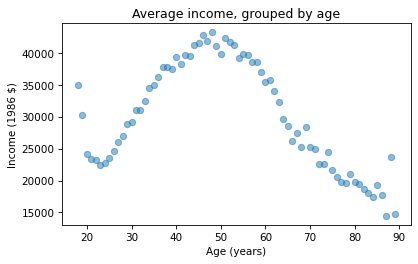

In [13]:
# group by age
import matplotlib.pyplot as plt

grouped = gss.groupby('age')
type(grouped)
mean_income_by_age = grouped['realinc'].mean()

plt.plot(mean_income_by_age, 'o', alpha=0.5)
plt.xlabel('Age (years)')
plt.ylabel('Income (1986 $)')
plt.title('Average income, grouped by age');

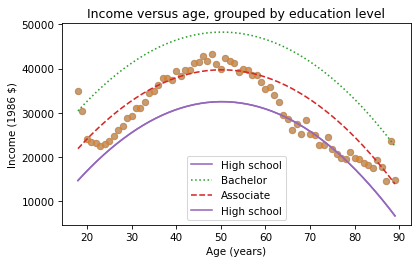

In [20]:
# Quadratic age and ed
import numpy as np

gss['age2'] = gss['age']**2
gss['educ2'] = gss['educ']**2
model = smf.ols('realinc ~ educ + educ2 + age + age2', data=gss)
results = model.fit()
results.params

df = pd.DataFrame()
df['age'] = np.linspace(18, 89)
df['age2'] = df['age']**2
df['educ'] = 12
df['educ2'] = df['educ']**2

pred12 = results.predict(df)

plt.plot(mean_income_by_age, 'o', alpha=0.5)
plt.plot(df['age'], pred12, label='High school', color='C4')

df['educ'] = 16
df['educ2'] = df['educ']**2
pred16 = results.predict(df)

df['educ'] = 14
df['educ2'] = df['educ']**2
pred14 = results.predict(df)

plt.plot(mean_income_by_age, 'o', alpha=0.5)
plt.plot(df['age'], pred16, ':', label='Bachelor')
plt.plot(df['age'], pred14, '--', label='Associate')
plt.plot(df['age'], pred12, label='High school', color='C4')

plt.xlabel('Age (years)')
plt.ylabel('Income (1986 $)')
plt.title('Income versus age, grouped by education level')
plt.legend();

In [21]:
#categorical - sex

formula = 'realinc ~ educ + educ2 + age + age2 + C(sex)'
results = smf.ols(formula, data=gss).fit()
results.params

Intercept       -24635.767539
C(sex)[T.2.0]    -4891.439306
educ              -496.623120
educ2              156.898221
age               1720.274097
age2               -17.097853
dtype: float64

Optimization terminated successfully.
         Current function value: 0.544026
         Iterations 5


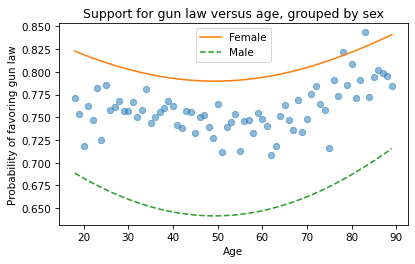

In [25]:
#
gss['gunlaw'] = gss['gunlaw'].replace([2], [0]) # make binary 0 = no, 1= yes
gss['gunlaw'].value_counts()
formula = 'gunlaw ~ age + age2 + educ + educ2 + C(sex)'
results = smf.logit(formula, data=gss).fit()
results.params

df = pd.DataFrame()
df['age'] = np.linspace(18, 89)
df['educ'] = 12
df['age2'] = df['age']**2
df['educ2'] = df['educ']**2

df['sex'] = 1
pred_male = results.predict(df)
df['sex'] = 2
pred_female = results.predict(df)

grouped = gss.groupby('age')
favor_by_age = grouped['gunlaw'].mean()

plt.plot(favor_by_age, 'o', alpha=0.5)
plt.plot(df['age'], pred_female, label='Female')
plt.plot(df['age'], pred_male, '--', label='Male')

plt.xlabel('Age')
plt.ylabel('Probability of favoring gun law')
plt.title('Support for gun law versus age, grouped by sex')
plt.legend();